# Classes detections

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg

PyTorch version: 2.1.1+cu121


### Selecting the device on which the notebook will be running

In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

### Defining global variables

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32
LEARNING_RATE = 0.01

### Defining classes and printing on random element from each class

In [4]:
resources_folder = 'resources/classification/'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

loaded numpy bitmaps, 8 classes


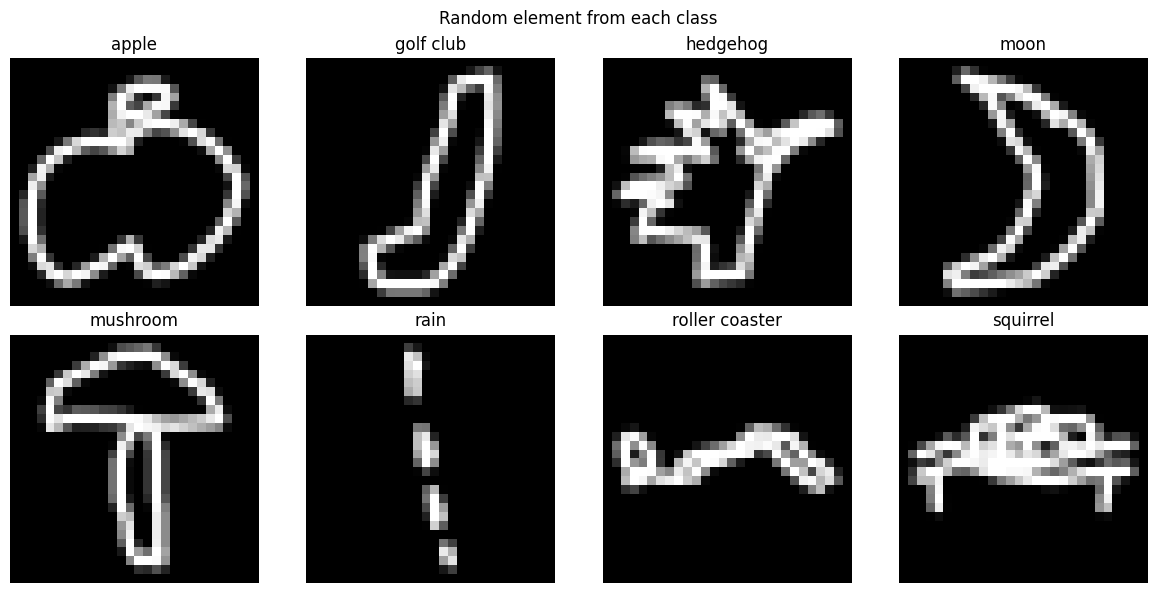

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

### Dataset creation

In [6]:
from dataset_creation.DataManager import DataManager

split = 0.8
data_manager = DataManager()

training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [8]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 40000

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:len_subset], labels=shuffled_validation_labels[:len_subset],
                             width=WIDTH, height=HEIGHT)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

### Model implementation

In [9]:
# YOUR CODE HERE

class Net(nn.Module):
    def __init__(self, width: int, device):
        nn.Module.__init__(self)

        self._device = device

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')

        self.pool = nn.MaxPool2d(2, 2)

        shape_after_conv = int(width/2/2)

        self.fc1 = nn.Linear(128 * shape_after_conv * shape_after_conv, 64)
        self.fc2 = nn.Linear(64, 8)

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.5)

        self.bn32 = nn.BatchNorm2d(num_features=32)
        self.bn64 = nn.BatchNorm2d(num_features=64)
        self.bn128 = nn.BatchNorm2d(num_features=128)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.bn32(x)
        x = self.dropout1(x)
        x = self.pool(self.bn64(F.relu(self.conv2(x))))
        x = self.pool(self.bn128(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        return x
    
    def predict(self, x):
        return self.softmax(self.forward(x))
    
    def fit(self, train_loader, valid_loader, nb_epochs:int =10, learning_rate=0.01):
        self.train()

        self.train_loss_history = []
        self.valid_loss_history = []
        self.train_acc_history = []
        self.valid_acc_history = []

        self.nb_epochs = [epoch+1 for epoch in range(nb_epochs)]

        import torch.optim as optim
        
        optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)

        criterion = nn.CrossEntropyLoss()

        start_time = time.time()

        for epoch in self.nb_epochs:

            train_running_loss = 0.0
            nb_batch = 0

            for i, data in enumerate(train_loader, start=0):
                nb_batch+=1
                inputs, labels = data
                inputs, labels = inputs.to(self._device), labels.to(self._device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()
                
            train_running_loss/=nb_batch
            valid_loss = self.compute_validation_loss(valid_loader, criterion)
            train_acc = self.compute_accuracy(train_loader)*100
            valid_acc = self.compute_accuracy(valid_loader)*100
            
            print(f'epoch [{epoch}/{len(self.nb_epochs)}]\ttrain loss : {round(train_running_loss, 3)}\tvalid loss : {round(valid_loss, 3)}\ttrain acc : {round(train_acc,3)}%\tvalid acc : {round(valid_acc,3)}%')
            self.train_loss_history.append(train_running_loss)
            self.valid_loss_history.append(valid_loss)
            self.train_acc_history.append(train_acc)
            self.valid_acc_history.append(valid_acc)
                    
        print('Finished Training')

        end_time = time.time()
        self.training_time = end_time - start_time

        self.eval()

    def compute_validation_loss(self, loader: DataLoader, criterion):
        running_loss = 0.0
        nb_batch = 0

        for i, data in enumerate(loader, start=0):
            nb_batch+=1
            inputs, labels = data
            inputs, labels = inputs.to(self._device), labels.to(self._device)

            outputs = self.forward(inputs)

            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
        running_loss/=nb_batch

        return running_loss

    def compute_accuracy(self, dataset: DataLoader):
        correct, total = 0, 0

        for data in dataset:
            inputs, labels = data
            inputs, labels = inputs.to(self._device), labels.to(self._device)

            outputs = self.forward(inputs)
            _, predicted_classes = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted_classes == labels).sum().item()

        return correct/total

### Modle training

In [10]:
model = Net(width=WIDTH, device=device)
model.to(device)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(f'number of trainable parameters : {sum([np.prod(p.size()) for p in model_parameters])}')

model.fit(training_loaded_set, validation_loaded_set, nb_epochs=EPOCHS)

number of trainable parameters : 495112
epoch [1/20]	train loss : 0.872	train loss : 0.667	train acc : 79.675%	valid acc : 79.7%
epoch [2/20]	train loss : 0.611	train loss : 0.623	train acc : 84.55%	valid acc : 84.3%


### Plotting metrics

In [ ]:
def plot_loss_and_accuracy_per_epoch(model):
    plt.plot(model.nb_epochs, model.train_loss_history, label='training')
    plt.plot(model.nb_epochs, model.valid_loss_history, label='validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('loss per epoch')
    plt.legend()
    plt.show()

    plt.plot(model.nb_epochs, model.train_acc_history, label='training')
    plt.plot(model.nb_epochs, model.valid_acc_history, label='validation')
    plt.ylabel('accuracy in %')
    plt.xlabel('epoch')
    plt.ylim(0, 100)
    plt.title('accuracy per epoch')
    plt.legend()
    plt.show()

In [ ]:
plot_loss_and_accuracy_per_epoch(model)

print(f'training accuracy : {model.compute_accuracy(training_loaded_set)*100} %')
print(f'validaiton accuracy : {model.compute_accuracy(validation_loaded_set)*100} %')

### Some predictions

In [ ]:
to_plot = []
predicted_classes = []

print_loader = DataLoader(validation_set, batch_size=8, shuffle=True)

for data in print_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model.predict(inputs)

    _, predicted = torch.max(outputs, 1)

    for predicted_class, input, label in zip(predicted, inputs, labels):
        to_plot.append(input.cpu())
        predicted_classes.append(f'expected : {classes[label]}\npredicted : {classes[predicted_class.item()]}')
        
    break

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(predicted_classes[i])

plt.tight_layout()
plt.suptitle('8 random predictions')

plt.subplots_adjust(top=0.85)

plt.show()